In [ ]:
import torchio as io
landmark = 'landmarks.npy'

In [2]:
a = None
if a==None:
    print("empty")

empty


In [4]:
import copy
import enum
from random import *
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import random; random.seed(seed)

import torchio as tio
from torchio import AFFINE, DATA

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm
#from livelossplot import PlotLosses

print('TorchIO version:', tio.__version__)

TorchIO version: 0.18.15


In [5]:
# Dataset
dataset_dir_name = 'nifti_data'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [6]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'mask'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        mask=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

ValueError: Subjects list is empty

In [4]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 33/33 [00:16<00:00,  2.06it/s]
Trained landmarks: [  0.      3.5     8.273  10.693  13.136  19.236  27.984  38.354  48.851
  53.85   58.857  70.308 100.   ]



In [9]:
training_split_ratio = 0.9  # use 80% of samples for training, 20% for testing

training_transform = tio.Compose([
    #tio.ToCanonical(),
    #tio.Resample(3),
    tio.CropOrPad((128, 128, 20),mask_name='mask'),
    #tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    #tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.1),
    tio.RandomFlip(axes=(0,)),
    #tio.OneOf({
    #    tio.RandomAffine(): 0.8,
    #    tio.RandomElasticDeformation(): 0.2,
    #}),
])

validation_transform = tio.Compose([
    #tio.ToCanonical(),
    #tio.Resample(3),
    tio.CropOrPad((128, 128, 20)),#mask_name='mask'),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 29 subjects
Validation set: 4 subjects


In [10]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size

patch_size = (48,48,4)
samples_per_volume = 6
max_queue_length = 300

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.data.UniformSampler(patch_size),
    num_workers=0,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.data.UniformSampler(patch_size),
    num_workers=0,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

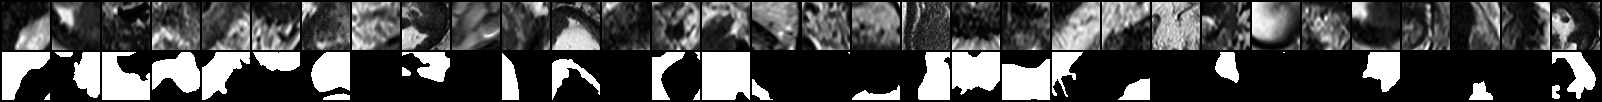

In [11]:
one_batch = next(iter(training_loader))
k = int(patch_size[2] // 4)
batch_mri = one_batch['mri'][DATA][..., k]
batch_label = one_batch['mask'][DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
save_image(slices, image_path, nrow=training_batch_size, normalize=True, scale_each=True)
display.Image(image_path)

In [12]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][DATA].to(device)
    foreground = batch['mask'][DATA].to(device)
    background = 1 - foreground
    targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return epoch_losses.mean()

def train(num_epochs, training_loader, validation_loader, model, optimizer):
    training_loss_values = []
    validation_loss_values = []
    best_val_loss = 1
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        training_loss = 0.0
        val_loss = 0.0
        print('Starting epoch', epoch_idx)

        lv_t = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        training_loss += lv_t
        training_loss_values.append(training_loss)

        lv_v = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        val_loss += lv_v
        validation_loss_values.append(val_loss)
        if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(dataset_dir, "best_metric_model.pth"))
                print("saved new best metric model")

    plt.figure(figsize=(12,5))    
    plt.plot(training_loss_values)
    plt.plot(validation_loss_values)
    plt.title("3D Unet Model Loss")
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.legend(['train', 'val'])

  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.614
Starting epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.519


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.615
saved new best metric model
Starting epoch 2


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.494


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.612
saved new best metric model
Starting epoch 3


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.474


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.491
saved new best metric model
Starting epoch 4


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.465


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.506
Starting epoch 5


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.464


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527
Starting epoch 6


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.462


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.539
Starting epoch 7


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.480


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.518
Starting epoch 8


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.431


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.505
Starting epoch 9


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.446


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504
Starting epoch 10


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.434


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.561
Starting epoch 11


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.458


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527
Starting epoch 12


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.422


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.547
Starting epoch 13


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.430


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.491
Starting epoch 14


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.409


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.476
saved new best metric model
Starting epoch 15


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.444


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.506
Starting epoch 16


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.411


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.533
Starting epoch 17


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.431


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.494
Starting epoch 18


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.411


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.487
Starting epoch 19


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.392


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.547
Starting epoch 20


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.401


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.587
Starting epoch 21


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.414


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.529
Starting epoch 22


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.415


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.518
Starting epoch 23


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.434


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483
Starting epoch 24


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.415


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503
Starting epoch 25


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.389


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.511
Starting epoch 26


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.396


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.515
Starting epoch 27


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.388


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.478
Starting epoch 28


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.398


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.489
Starting epoch 29


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.396


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.532
Starting epoch 30


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.389


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513
Starting epoch 31


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.384


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469
saved new best metric model
Starting epoch 32


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.414


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.534
Starting epoch 33


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.414


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.546
Starting epoch 34


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.398


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.505
Starting epoch 35


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.381


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.512
Starting epoch 36


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.393


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.512
Starting epoch 37


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.397


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.505
Starting epoch 38


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.400


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.497
Starting epoch 39


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.398


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.496
Starting epoch 40


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.369


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.500
Starting epoch 41


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.387


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502
Starting epoch 42


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.376


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469
Starting epoch 43


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.400


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.493
Starting epoch 44


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.407


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.544
Starting epoch 45


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.387


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.565
Starting epoch 46


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.390


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.490
Starting epoch 47


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.398


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.562
Starting epoch 48


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.401


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.560
Starting epoch 49


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.393


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503
Starting epoch 50


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.390


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.515
Starting epoch 51


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.360


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455
saved new best metric model
Starting epoch 52


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.400


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483
Starting epoch 53


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.377


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.494
Starting epoch 54


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.391


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.442
saved new best metric model
Starting epoch 55


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.388


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.496
Starting epoch 56


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.392


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.451
Starting epoch 57


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.367


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.482
Starting epoch 58


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.383


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.471
Starting epoch 59


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.393


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.506
Starting epoch 60


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.389


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.453
Starting epoch 61


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.367


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504
Starting epoch 62


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.394


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503
Starting epoch 63


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.385


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.510
Starting epoch 64


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.379


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.460
Starting epoch 65


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.385


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.450
Starting epoch 66


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.385


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.501
Starting epoch 67


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.392


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.522
Starting epoch 68


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.376


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.450
Starting epoch 69


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.361


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.474
Starting epoch 70


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.390


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.473
Starting epoch 71


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.371


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.566
Starting epoch 72


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.391


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.497
Starting epoch 73


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.402


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.442
saved new best metric model
Starting epoch 74


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.391


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.459
Starting epoch 75


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.380


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.461
Starting epoch 76


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.383


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.514
Starting epoch 77


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.366


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.473
Starting epoch 78


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.388


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.542
Starting epoch 79


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.384


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.493
Starting epoch 80


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.367


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.516
Starting epoch 81


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.380


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.516
Starting epoch 82


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.385


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.456
Starting epoch 83


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.381


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.563
Starting epoch 84


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.383


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468
Starting epoch 85


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.395


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468
Starting epoch 86


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.390


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.501
Starting epoch 87


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.393


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.507
Starting epoch 88


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.377


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.509
Starting epoch 89


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.389


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469
Starting epoch 90


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.379


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.465
Starting epoch 91


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.362


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.474
Starting epoch 92


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.383


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.496
Starting epoch 93


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.384


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.521
Starting epoch 94


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.353


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.414
saved new best metric model
Starting epoch 95


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.352


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.489
Starting epoch 96


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.374


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.532
Starting epoch 97


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.377


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.488
Starting epoch 98


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.362


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.531
Starting epoch 99


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.395


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.471
Starting epoch 100


  0%|          | 0/6 [00:00<?, ?it/s]

Training mean loss: 0.361


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527


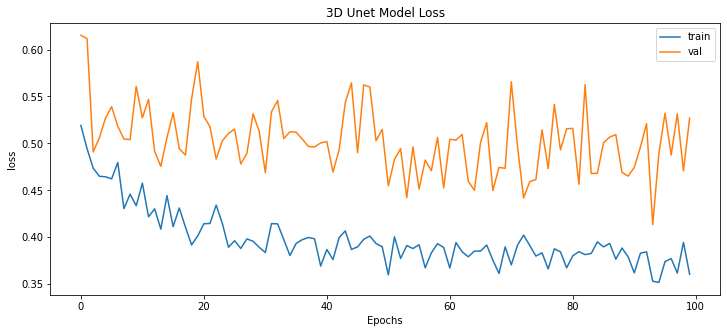

In [13]:
num_epochs = 100

model, optimizer = get_model_and_optimizer(device)
train(num_epochs, training_loader, validation_loader, model, optimizer)

In [14]:
#@title (Helper functions, double-click here to expand)
def show_nifti(image_path_or_image, colormap='gray'):
    if isinstance(image_path_or_image, nib.AnalyzeImage):
        nii = image_path_or_image
    else:
        image_path = image_path_or_image
        nii = nib.load(str(image_path))
    k = int(nii.shape[-1] / 2)
    plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_subject(subject, image_name, label_name=None):
    if label_name is not None:
        subject = copy.deepcopy(subject)
        affine = subject[label_name].affine
        label_image = subject[label_name].as_sitk()
        label_image = sitk.Cast(label_image, sitk.sitkUInt8)
        border = sitk.BinaryContour(label_image)
        border_array, _ = tio.io.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)[0]
        image_tensor = subject[image_name].data[0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        subject[image_name].save('temp.nii')
        show_nifti('temp.nii')

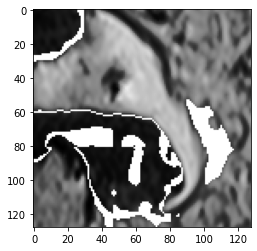

In [15]:
sample = random.choice(validation_set)
input_tensor = sample.mri.data[0]
patch_size = 48, 48, 8  # we can user larger patches for inference
patch_overlap = 2, 2, 2
grid_sampler = tio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['mri'][DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

foreground = aggregator.get_output_tensor()
affine = sample.mri.affine
label_image = tio.io.nib_to_sitk(foreground, affine)
border = sitk.BinaryContour(label_image)
border_array, _ = tio.io.sitk_to_nib(border)
input_tensor[border_array > 0.5] = input_tensor.max()
nii = nib.Nifti1Image(input_tensor.numpy(), affine)
show_nifti(nii)

In [17]:
def plot_image_and_mask_evaluate(batch_data, predicted):
    valid_img = batch_data['mri'][DATA]
    valid_mask = batch_data['mask'][DATA]
    valid_img_o = valid_img.cpu().numpy()
    valid_mask_o = valid_mask.cpu().numpy()
    predicted_label = predicted.cpu().numpy().astype(np.uint8)

    fig, axs = plt.subplots(len(valid_img_o[0,0,0,:]),4, figsize=(14,30))
    count = 0
    for i in range(len(valid_img_o[0,0,0,:])):
        img_original = np.transpose(valid_img_o[:,:,:,i],(1,2,0))
        img_prediction = np.transpose(valid_img_o[:,:,:,i],(1,2,0))
        original_mask = np.transpose(valid_mask_o[:,:,:,i],(1,2,0))
        predicted_mask = np.transpose(predicted_label[:,:,:,i],(1,2,0))

        axs[count][0].title.set_text("MRI T2 WI rectal") # set title
        axs[count][0].imshow(img_original, cmap='gray') # show MRI 
        axs[count][1].title.set_text("Ground Truth") # plot title on the mask 
        axs[count][1].imshow(original_mask, cmap='gray') # Show ground truth mask
        axs[count][2].title.set_text('AI predicted mask')
        axs[count][2].imshow(predicted_mask, cmap='gray') # Show predicted mask
        #overlay original mask with MRI
        overay_mask = original_mask.copy()
        overay_mask[predicted_mask.copy()==1] = 5
        substract_b_a = predicted_mask.copy() - original_mask.copy()
        overay_mask[substract_b_a.copy()==1] = 1
        axs[count][3].imshow(overay_mask, cmap='Reds',alpha = 1)
        axs[count][3].title.set_text('Overay GT and predicted mask')
        count += 1
    fig.tight_layout()
    return print("prediction completed")

prediction completed


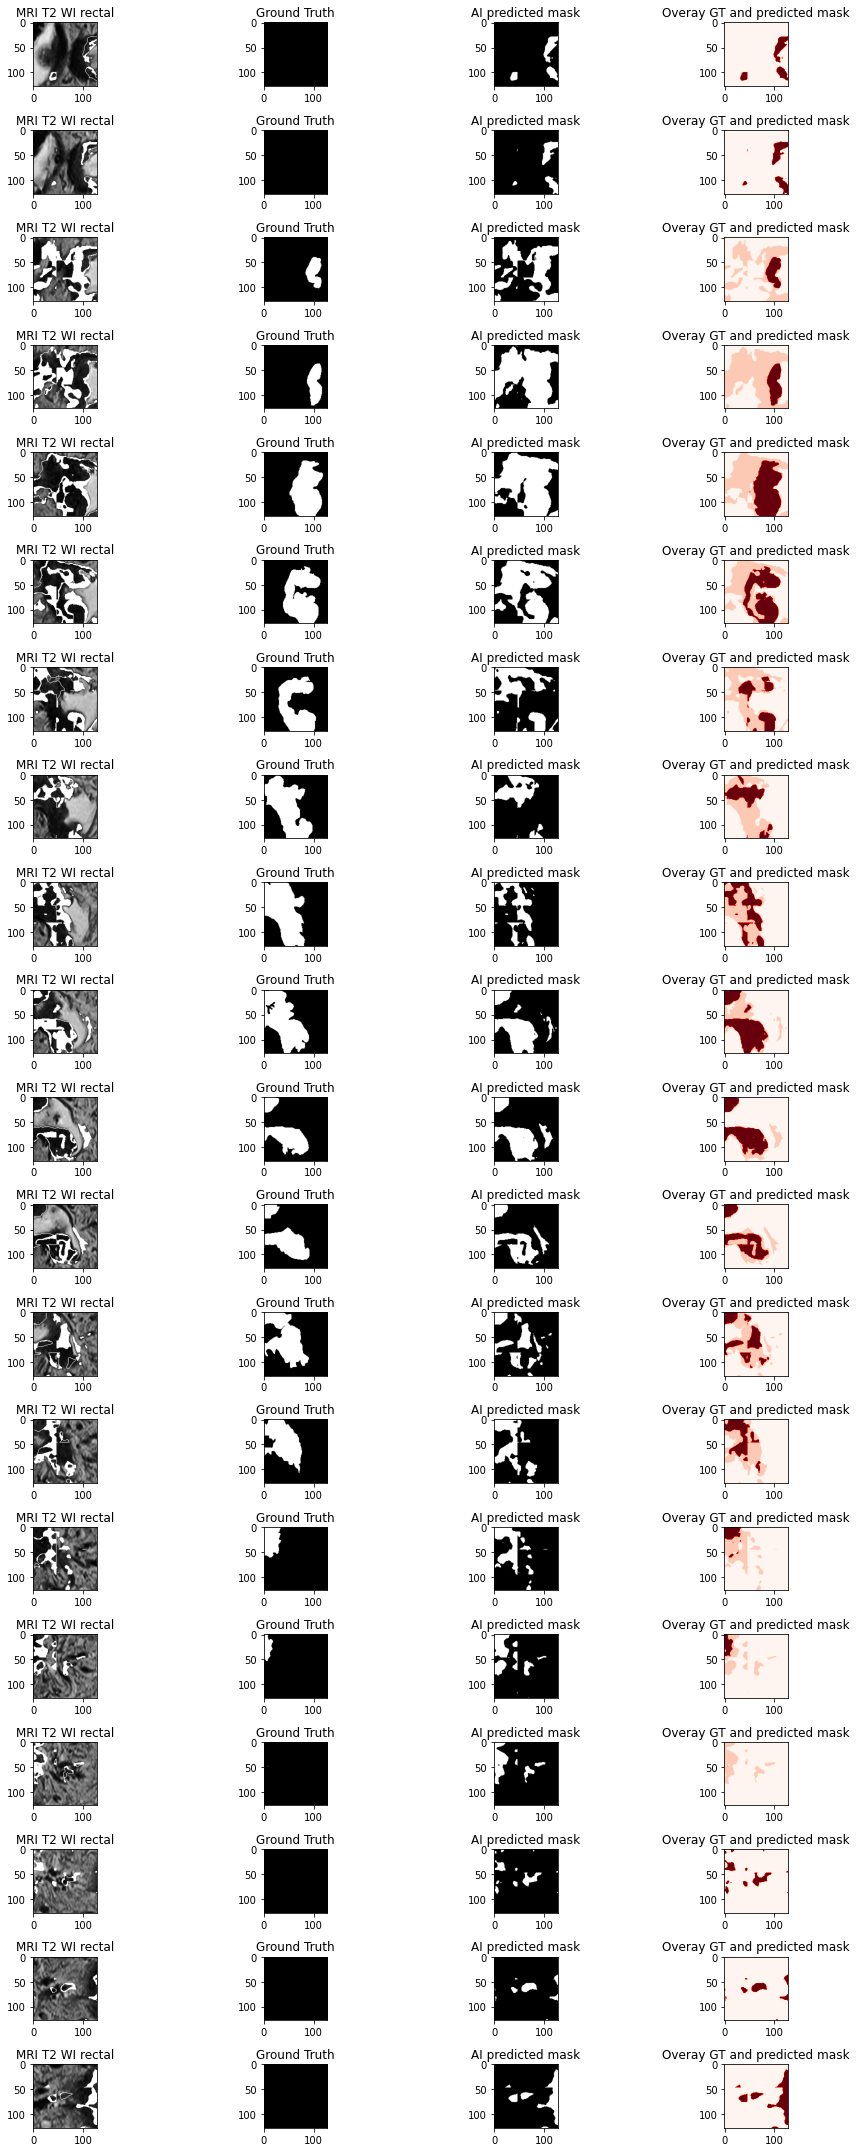

In [18]:
plot_image_and_mask_evaluate(sample, foreground)